In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2022-10-05 13:34 (eradiate v0.22.4.post102+g84ef86b.d20221005)*

## Importing modules

We start by importing the `eradiate` module.
We also import a few utility libraries:

* the Numpy scientific library for array computation;
* Matplotlib's `pyplot` interface to visualise our results.

In [2]:
import eradiate
import numpy as np
import matplotlib.pyplot as plt

We can now select an operational mode and add some aliases to submodules of Eradiate for convenience.

We will perform monochromatic simulations---for a single wavelength. The corresponding operational mode is called `mono`.

In [3]:
eradiate.set_mode("mono")

The simulation is performed on a *scene* composed of scattering objects (*e.g.* surface, canopy, atmosphere) and illumination conditions.

**Note:** In the spirit of its radiometric kernel Mitsuba, Eradiate also includes its scenes some components which are usually not considered to be part of the radiative transfer process, such as sensors or algorithms used to sample the radiative transfer equation. The reason to that is that all these components participate in the simulation of the measurement.

In [4]:
import eradiate.scenes as ertsc

Eradiate manages physical quantities with [Pint](https://pint.readthedocs.io/). Pint handles unit conversions automatically and ensures that user-specified quantities are given in units compatible with Eradiate's internals. This makes scene creation more convenient as all objects can be described in natural units. 

**Example:** On the one hand, the altitude of the top-of-atmosphere level is naturally expressed in kilometers; on the other hand, the radius of a leaf in a canopy is more intuitively specified in centimeters. Eradiate's unit handling system makes it possible for the user to provide its input using both units at the same time. 

Numbers are turned into physical quantities using a Pint *unit registry*. For convenience, we alias it as well.

In [5]:
from eradiate import unit_registry as ureg

## Defining an experiment

We start by defining our surface. It is characterised by its geometry and its radiative properties. The geometry is constrained by the experiment we are running and we consequently don't have to specify it---Eradiate will set it automatically.

The surface scatters radiation according to its *bidirectional reflectance distribution function* ([BRDF](https://en.wikipedia.org/wiki/Bidirectional_reflectance_distribution_function)), generalised as a *bidirectional scattering distribution function* ([BSDF](https://en.wikipedia.org/wiki/Bidirectional_scattering_distribution_function)). We will use a Lambertain reflectance, which models an ideal surface scattering light equally in every direction.

In [6]:
surface_bsdf = ertsc.bsdfs.LambertianBSDF(reflectance=0.5)

Our experiment also features a scattering atmosphere. We will use a simple atmospheric model consisting only of scattering molecules (no aerosols). In monochromatic mode, Eradiate supports only the [U.S. Standard Atmosphere (1976)](https://en.wikipedia.org/wiki/U.S._Standard_Atmosphere). This model is not designed for atmospheric radiative transfer and should not be used to simulate satellite images (but you should not use the monochromatic mode in that case either, anyway).

We therefore instantiate a molecular atmosphere model, using the U.S. Standard Atmosphere (1976) constructor.

In [7]:
atmosphere = ertsc.atmosphere.MolecularAtmosphere.ussa_1976()

We illuminate the scene using a directional illumination model, parametrised by the Sun zenith and azimuth angles. We do not specify the irradiance spectrum and let Eradiate assign a default value (in that case, the `thuillier_2003` Solar irradiance dataset).

In [8]:
illumination = ertsc.illumination.DirectionalIllumination(
    zenith=15.0, azimuth=0.0
)

Finally, we define the measurement performed during our experiment. We will record the radiance leaving the scene at infinite distance with a *distant* measure in the principal plane, *i.e.* the angular domain with constant azimuth equal to the Sun azimuth angle---which we set to 0° when we specified our illumination conditions.

Our measure has a spectral configuration (`spectral_cfg` parameter) which defines for which wavelengths this monochromatic simulation will be performed. If multiple wavelengths are requested, Eradiate will automatically loop on them and the output dataset will contain a wavelength dimension.

Finally, an `spp` parameter defines the number of radiance samples taken for each direction. We set it to a value ensuring acceptable precision and a short run time (this is our first simulation, we want to see the result quickly!).

**Note:** What does the "SPP" acronym mean? Internally, the measure instantiates a kernel-level sensor which records its radiance samples to a data structure divided into *pixels*. SPP therefore stands for *samples per pixel*.

In [9]:
measure = ertsc.measure.MultiDistantMeasure.from_viewing_angles(
    id="toa_brf",
    zeniths=np.arange(-75, 76, 5),
    azimuths=0,
    spectral_cfg={"wavelengths": [550]},
    spp=10000,
)

In [10]:
exp = eradiate.experiments.AtmosphereExperiment(
    surface=surface_bsdf,
    atmosphere=atmosphere,
    illumination=illumination,
    measures=measure,
)

## Running the simulation and visualising the results

In [11]:
results = eradiate.run(exp)

This function call returns an xarray dataset, which encapsulates a collection of labelled arrays and provides a convenient interface to browse and visualise data. A post-processing pipeline was automatically executed, additionally deriving the BRDF and the *bidirectional reflectance factor* (BRF) from the simulated radiance. Let's take a look at our dataset:

In [12]:
results

<xarray.Dataset>
Dimensions:     (sza: 1, saa: 1, y_index: 1, x_index: 31, w: 1, srf_w: 1)
Coordinates:
  * sza         (sza) float64 15.0
  * saa         (saa) float64 0.0
  * y_index     (y_index) int64 0
    y           (y_index) float64 0.0
  * x_index     (x_index) int64 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29 30
    x           (x_index) float64 0.0 0.03333 0.06667 0.1 ... 0.9333 0.9667 1.0
  * w           (w) int64 550
    vza         (x_index, y_index) float64 -75.0 -70.0 -65.0 ... 65.0 70.0 75.0
    vaa         (x_index, y_index) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * srf_w       (srf_w) int64 550
Data variables:
    radiance    (sza, saa, w, y_index, x_index) float64 0.2837 0.2844 ... 0.2918
    spp         (sza, saa, w) int64 10000
    irradiance  (sza, saa, w) float64 1.815
    srf         (srf_w) float64 1.0
    brdf        (sza, saa, w, y_index, x_index) float64 0.1563 0.1566 ... 0.1607
    brf         (sza, saa, w, y_index, x_index) float64 0.491 0.4921 ... 0.505
Attributes:
    convention:  CF-1.8
    source:      eradiate, version 0.22.4.post102+g84ef86b.d20221005
    history:     2022-10-05 13:34:21 - data creation - AtmosphereExperiment.p...
    references:  
    title:       Top-of-atmosphere simulation results

We can see that a `brf` variable is present. To visualise it, we create a Matplotlib figure and plot the BRF data, using xarray's built-in plotting interface. By passing the x coordinate in the plotting method, we choose which coordinate to plot against. We also set markers and line style to visualise sample location more precisely.

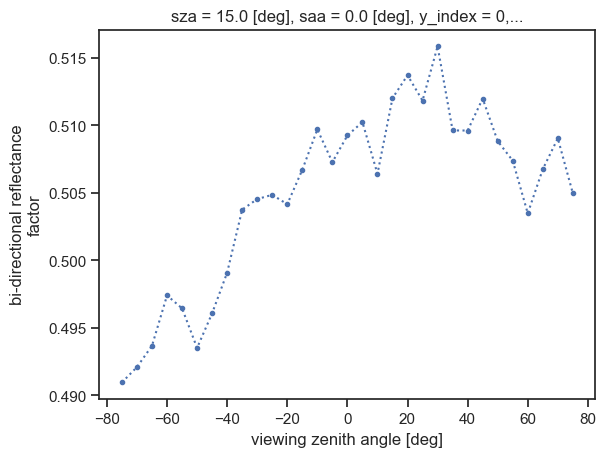

In [13]:
fig = plt.figure()
results.brf.plot(x="vza", linestyle=":", marker=".");